In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import os.path
from os.path import join
import numpy as np
import imodelsx
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import data
files_dict = data.load_files_dict_single_site()

[2024-01-15 19:29:10,624] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


Kevin_AnnArbor_LosAngeles_SaltLakeCity
Jonathan_Indianapolis_Milwaukee_Pittsburgh
Katie_Dallas_Seattle_Tucson


/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Spencer_Denver_Sacramento
Patty_Charlotte_Houston_Portland
Corina_Buffalo_Cincinnati_SanFrancisco
Manish_Atlanta_Columbus_WashingtonDC
success: 0
fail: ['Los Angeles COMPLETE', 'Salt Lake City', 'Ann Arbor', 'Pittsburgh', 'Milwaukee', 'Indianapolis', 'Tucson', 'Dallas', 'Seattle', 'Denver', 'Sacramento', 'Houston', 'Charlotte', 'Portland', 'Cincinnati', 'San Francisco', 'Buffalo', 'Columbus', 'WashingtonDC', 'Atlanta']


/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### Filter data for single-site analysis

In [ ]:
k = 'Atlanta'
# k = 'Columbus'
df = files_dict[k]
theme_index = np.where(
    np.array(list(map(str.lower, df.columns.values))) == 'theme')[0][0]
col_vals = df.columns[4: theme_index]

# separate into relevant pieces
qs = df['Subcategory']
responses_df = df[col_vals]
themes_df = df[df.columns[theme_index:]]

### Run sentiment

In [ ]:
sentiment_prompt = '''### You are given a question and a response. Rate the sentiment/supportiveness of the response on a scale of 1 to 5, where 1 is very negative and 5 is very positive. ###

Question: {question}

Response: {response}

Rating (1-5):'''

llm = imodelsx.llm.get_llm('gpt-4', repeat_delay=3)

num_questions = len(qs)
sentiments = defaultdict(list)
for question_num in tqdm(range(num_questions), position=0):
    question, responses, theme_dict = data.get_data_for_question_single_site(
        question_num=question_num, qs=qs, responses_df=responses_df, themes_df=themes_df)
    for response_num in tqdm(range(len(responses)), position=1):
        response = responses.values[response_num]

        if pd.isna(response):
            sentiments[question_num].append(np.nan)
        else:
            prompt = sentiment_prompt.format(
                question=question.strip(), response=response.strip())
            sentiments[question_num].append(llm(prompt))

### Plot sentiment

/tmp/ipykernel_2140731/3316632921.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_df['Value'][idxs] = sent_df['Value'][idxs].astype(float).round()


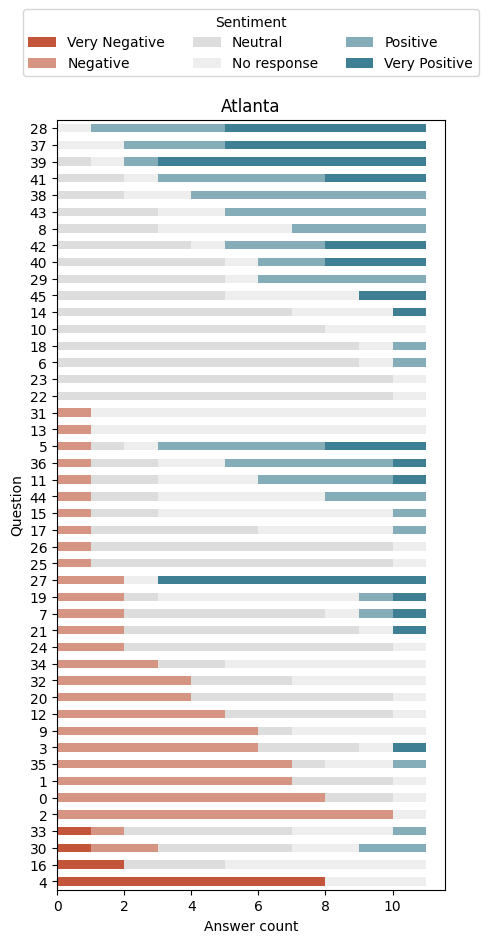

In [229]:
sent_df = pd.DataFrame([(key, var) for (key, L) in sentiments.items() for var in L],
                       columns=['Question', 'Value'])

# round  values
idxs = sent_df['Value'].notna()
sent_df['Value'][idxs] = sent_df['Value'][idxs].astype(float).round()
value_maps = {
    1: 'Very Negative',
    2: 'Negative',
    3: 'Neutral',
    4: 'Positive',
    5: 'Very Positive',
}
sent_df['Value'] = sent_df['Value'].map(value_maps.get)
sent_df['Value'] = sent_df['Value'].fillna('No response')

sent_df = sent_df.groupby(['Question', 'Value']).size().unstack(fill_value=0)
levels = ['Very Negative', 'Negative', 'Neutral',
          'No response', 'Positive', 'Very Positive']
sent_df = sent_df.reindex(levels, axis=1)
sent_df = sent_df.sort_values(by=levels, ascending=False)

# set colors
colors = sns.diverging_palette(20, 220, n=6).as_hex()
colors = colors[:2] + ['#ddd', '#eee'] + colors[-2:]
sent_df.plot(kind='barh', stacked=True, figsize=(5, 10), color=colors)

# move legend to top
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncol=3, title='Sentiment')
plt.xlabel('Answer count')
plt.title(k)
plt.savefig('../figs/sentiment_example.pdf', bbox_inches='tight')
plt.show()